In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve

from imblearn.pipeline import Pipeline
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# from xgboost import XGBClassifier

from metric_utils import get_model_metrics
from global_utils import get_globals

## Content Table:
1. [Globals](#1-bullet)
2. [Params and Strategies](#2-bullet)
3. [Grid Search CV](#3-bullet)
    1. [Comparison between using or not GridSearch](#3.1-bullet)
4. [Visualizations](#4-bullet)
    1. [Comparinson Between Train and Test Metric Scores](#4.1-bullet)
    2. [How C Param affect LogReg Metric Scores](#4.2-bullet)
    3. [Performance Comparison Between GridSearch Experiments](#4.3-bullet)

## Globals <a class="anchor" id="1-bullet"></a>

In [2]:
## Globals
DATA_PATH = get_globals().get('DATA_PATH')
COLORS = get_globals().get('COLORS')
RANDOM_STATE = get_globals().get('RANDOM_STATE')
TEST_SIZE = get_globals().get('TEST_SIZE')

# model params
MAX_DEPTH = get_globals().get('MAX_DEPTH')
ITER = get_globals().get('ITER')
N_JOBS = get_globals().get('N_JOBS')

# cross validation params
N_SPLITS = 5
N_REPEATS = 2
SCORING = get_globals().get('SCORING')

## Params and Strategies <a class="anchor" id="2-bullet"></a>

In [3]:
df = pd.read_csv(DATA_PATH)
X, y = df.drop(columns=['Class']), df['Class']

In [4]:
# resampling strategies
ros = RandomOverSampler(random_state=RANDOM_STATE)
rus = RandomUnderSampler(random_state=RANDOM_STATE)
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE, k_neighbors=5, n_jobs=N_JOBS)

# estimators
lrc = LogisticRegression(random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
rfc = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
# xgb = XGBClassifier(n_jobs=N_JOBS)

# cross validation strategy
cv = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## GridSearch<a class="anchor" id="3-bullet"></a>

In [6]:
## Logistic Regression + GridSearch

# LogReg + Grid
param_grid_lrc = {'C': np.logspace(-3, 1.1, 10),}
grid_lrc = GridSearchCV(
    lrc, param_grid_lrc, scoring=SCORING, cv=cv, refit='f1', n_jobs=N_JOBS, 
    return_train_score=True)
grid_lrc.fit(X_train, y_train);

# ROS + LogReg + Grid
param_grid_ros_lrc = {
    'resampling__sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
    'logistic__C': np.logspace(-3, 1.1, 10)}
pipe_ros_lrc = Pipeline([('resampling', ros), ('logistic', lrc)])
grid_ros_lrc = GridSearchCV(
    pipe_ros_lrc, param_grid_ros_lrc, scoring=SCORING, cv=cv, refit='f1', 
    n_jobs=N_JOBS, return_train_score=True)
grid_ros_lrc.fit(X_train, y_train);

# RUS + LogReg + Grid
param_grid_rus_lrc = {
    'resampling__sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
    'logistic__C': np.logspace(-3, 1.1, 10)}
pipe_rus_lrc = Pipeline([('resampling', rus), ('logistic', lrc)])
grid_rus_lrc = GridSearchCV(
    pipe_rus_lrc, param_grid_rus_lrc, scoring=SCORING, cv=cv, refit='f1', 
    n_jobs=N_JOBS, return_train_score=True)
grid_rus_lrc.fit(X_train, y_train);

# SMOTE + LogReg + Grid
param_grid_smote_lrc = {
    'resampling__sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
    'logistic__C': np.logspace(-3, 1.1, 10)}
pipe_smote_lrc = Pipeline([('resampling', smote), ('logistic', lrc)])
grid_smote_lrc = GridSearchCV(
    pipe_smote_lrc, param_grid_smote_lrc, scoring=SCORING, cv=cv, refit='f1', 
    n_jobs=N_JOBS, return_train_score=True)
grid_smote_lrc.fit(X_train, y_train);

/opt/miniconda3/envs/fraud/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/fraud/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/fraud/lib/python3.9/site-packages/imblearn/pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "/opt/miniconda3/envs/fraud/lib/python3.9/site-packages/imblearn/pipeline.py", line 226, in _fit
    X, y, fitted_transforme

In [7]:
rank_metric_cv_result = [
    k for k in grid_lrc.cv_results_.keys() 
    if k.startswith('rank_')]
mean_test_metric_cv_result = [
    k for k in grid_lrc.cv_results_.keys() 
    if k.startswith('mean_test_')]
mean_train_metric_cv_result = [
    k for k in grid_lrc.cv_results_.keys() 
    if k.startswith('mean_train_')]
mean_metric_cv_result = mean_test_metric_cv_result + mean_train_metric_cv_result

df_grid_lrc = pd.DataFrame(grid_lrc.cv_results_)
df_grid_ros_lrc = pd.DataFrame(grid_ros_lrc.cv_results_)
df_grid_rus_lrc = pd.DataFrame(grid_rus_lrc.cv_results_)
df_grid_smote_lrc = pd.DataFrame(grid_smote_lrc.cv_results_)

In [8]:
grid_exp_list = [
    ('LogReg + Grid', df_grid_lrc), 
    ('ROS + LogReg + Grid', df_grid_ros_lrc),
    ('RUS + LogReg + Grid', df_grid_rus_lrc),
    ('SMOTE + LogReg + Grid', df_grid_smote_lrc),
]

best_params_per_metric = []
for exp_id, df in grid_exp_list:
    for metric in [k for k in grid_lrc.cv_results_.keys() if k.startswith('mean_test_')]:
        mask = df[metric] == df[metric].max()
        rank = metric.replace('mean_test_', 'rank_test_')
        best_params_per_metric.append({
            'exp_id': exp_id,
            'metric_name': metric.replace('mean_test_', '').replace('_', ' '),
            'index': df[mask].index[0],
            'metric_score': df[metric].max(),
            'best_params_': df.loc[mask, 'params'].values[0]
        })

### Comparison between using or not GridSearch <a class="anchor" id="3.1-bullet"></a>

In [9]:
# def experiment():
#     # ROS + LogReg
#     pipe_ros_lrc = Pipeline([('resampling', ros), ('logistic', lrc)])
#     pipe_ros_lrc.fit(X_train, y_train)
#     y_pred_ros_lrc = pipe_ros_lrc.predict(X_test)
#     metrics_ros_lrc = get_model_metrics(y_test, y_pred_ros_lrc, 'ROS + LogReg', True)

#     # ROS + LogReg + Grid
#     ros_grid = RandomOverSampler(
#         sampling_strategy=grid_ros_lrc.best_params_['resampling__sampling_strategy'], 
#         random_state=RANDOM_STATE)
#     lrc_grid = LogisticRegression(
#         C=grid_ros_lrc.best_params_['logistic__C'], 
#         random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
#     pipe_ros_lrc_grid = Pipeline([('resampling', ros_grid), ('logistic', lrc_grid)])
#     pipe_ros_lrc_grid.fit(X_train, y_train)
#     y_pred_ros_lrc_grid = pipe_ros_lrc_grid.predict(X_test)
#     metrics_ros_lrc_grid = get_model_metrics(y_test, y_pred_ros_lrc_grid, 'ROS + LogReg + Grid', True)

In [10]:
### comparison between no-grid-search and grid-search

## Logistic Regression
# LogReg
lrc.fit(X_train, y_train)
y_pred_lrc = lrc.predict(X_test)
metrics_lrc = get_model_metrics(y_test, y_pred_lrc, 'LogReg', False)

# LogReg + Grid
lrc_grid = LogisticRegression(
    C=grid_lrc.best_params_['C'],
    random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
lrc_grid.fit(X_train, y_train)
y_pred_lrc_grid = lrc_grid.predict(X_test)
metrics_lrc_grid = get_model_metrics(y_test, y_pred_lrc_grid, 'LogReg + Grid', False)


# ROS + LogReg
pipe_ros_lrc = Pipeline([('resampling', ros), ('logistic', lrc)])
pipe_ros_lrc.fit(X_train, y_train)
y_pred_ros_lrc = pipe_ros_lrc.predict(X_test)
metrics_ros_lrc = get_model_metrics(y_test, y_pred_ros_lrc, 'ROS + LogReg', True)

# ROS + LogReg + Grid
ros_grid = RandomOverSampler(
    sampling_strategy=grid_ros_lrc.best_params_['resampling__sampling_strategy'], 
    random_state=RANDOM_STATE)
lrc_grid = LogisticRegression(
    C=grid_ros_lrc.best_params_['logistic__C'], 
    random_state=RANDOM_STATE, max_iter=ITER, n_jobs=N_JOBS)
pipe_ros_lrc_grid = Pipeline([('resampling', ros_grid), ('logistic', lrc_grid)])
pipe_ros_lrc_grid.fit(X_train, y_train)
y_pred_ros_lrc_grid = pipe_ros_lrc_grid.predict(X_test)
metrics_ros_lrc_grid = get_model_metrics(y_test, y_pred_ros_lrc_grid, 'ROS + LogReg + Grid', True)

## Visualizations <a class="anchor" id="4-bullet"></a>

### Comparinson Between Train and Test Metric Scores <a class="anchor" id="4.1-bullet"></a>

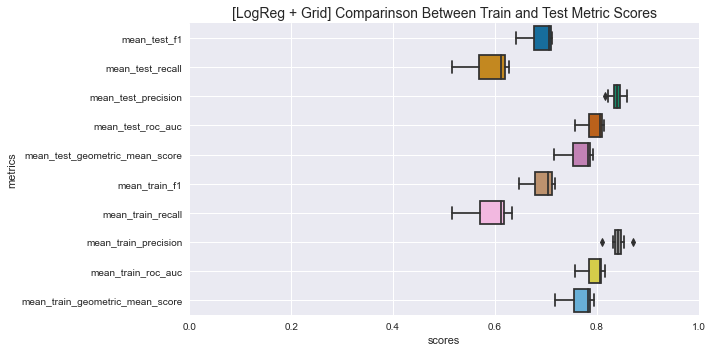

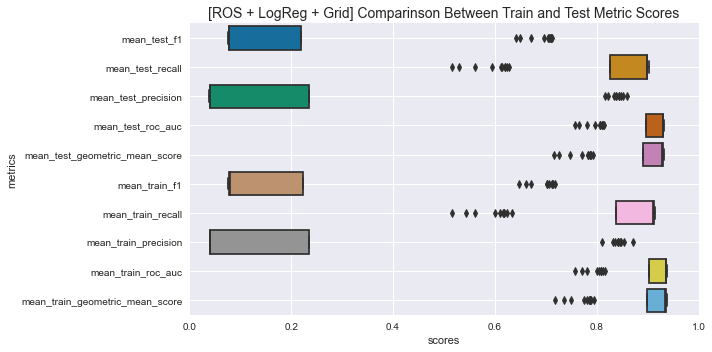

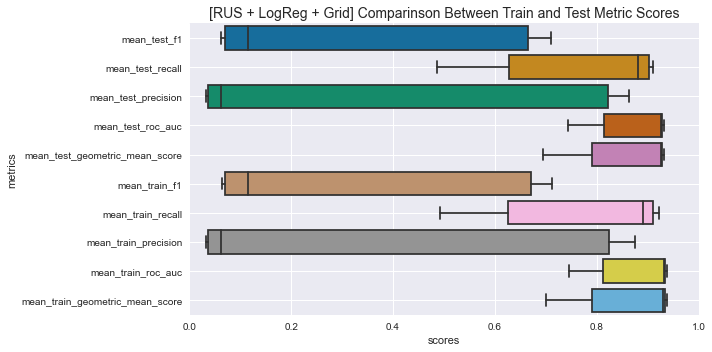

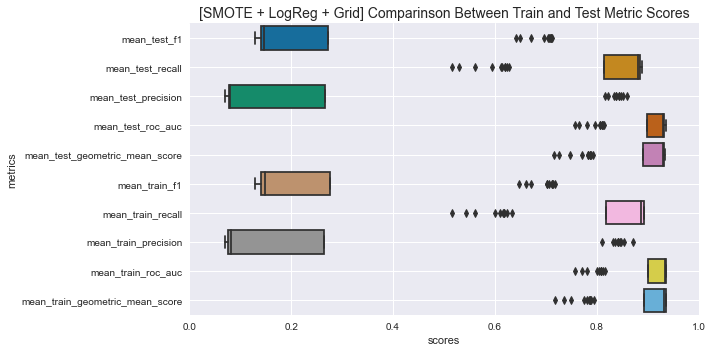

In [11]:
for exp, df in grid_exp_list:
    _ = plt.figure(figsize=[10,5])
    sns.boxplot(data=df[mean_metric_cv_result], orient='h', palette='colorblind')
    plt.title(f'[{exp}] Comparinson Between Train and Test Metric Scores', fontsize=14)
    plt.xlabel('scores')
    plt.xlim([0,1])
    plt.ylabel('metrics')
    plt.grid(True)
    plt.tight_layout()

### How C Param affect LogReg Metric Scores <a class="anchor" id="4.2-bullet"></a>

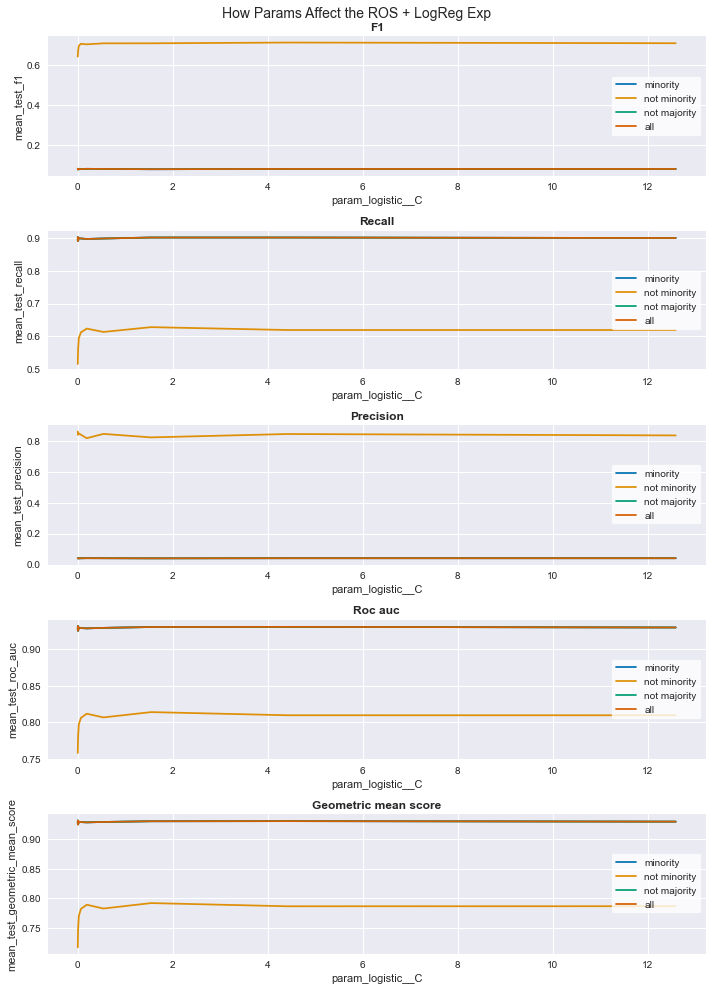

In [12]:
## df_grid_ros_lrc

_ = plt.figure(figsize=[10,14])
plt.suptitle('How Params Affect the ROS + LogReg Exp', fontsize=14)

for i, metric in enumerate(SCORING.keys()):
    cols = ['param_logistic__C', 'param_resampling__sampling_strategy', f'mean_test_{metric}']
    
    plt.subplot(SCORING.__len__(),1 ,i+1)
    sns.lineplot(
        data=df_grid_ros_lrc[cols],
        x='param_logistic__C',
        y=f'mean_test_{metric}',
        hue='param_resampling__sampling_strategy',
        palette='colorblind')
    plt.title(metric.replace('_', ' ').capitalize(), fontweight='bold')
    plt.legend(loc='center right', frameon=True) \
        .get_frame() \
        .set_color('white')
plt.tight_layout()

### Performance Comparison Between GridSearch Experiments <a class="anchor" id="4.3-bullet"></a>

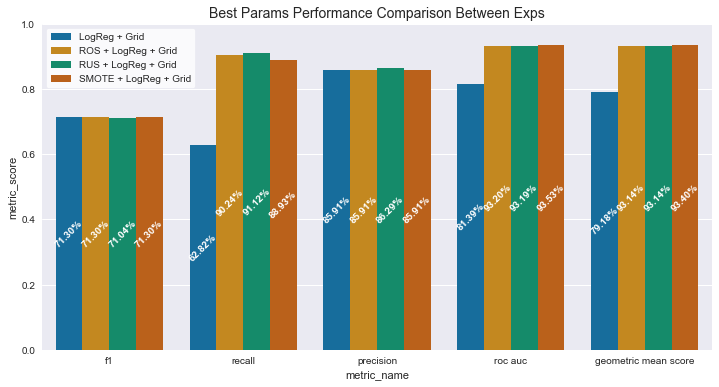

In [13]:
_ = plt.figure(figsize=[12,6])
plt.title('Best Params Performance Comparison Between Exps', fontsize=14)
FMT = '%.3f%%'
ax = sns.barplot(
    data=pd.DataFrame(best_params_per_metric),
    x='metric_name',
    y='metric_score',
    hue='exp_id',
    palette='colorblind')
plt.ylim([0,1])
for container in ax.containers:
    labels = [f'{value:.2f}%' for value in container.datavalues*100]
    ax.bar_label(container,  labels=labels,  label_type='center', 
                 weight='bold', color='white',  rotation=45)
plt.legend(loc='upper left', frameon=True) \
    .get_frame() \
    .set_color('white')